In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

df = pd.read_csv("preprocessed_telesurgery_data.csv")  
X = df.drop("Threat Detected", axis=1)
y = df["Threat Detected"]


cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


X_train_tree = X_train.copy()
X_test_tree = X_test.copy()
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X_train_tree[col] = le.fit_transform(X_train[col])
    X_test_tree[col] = le.transform(X_test[col])
    label_encoders[col] = le


X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

smote = SMOTE(random_state=42)
X_train_tree_bal, y_train_tree_bal = smote.fit_resample(X_train_tree, y_train)
X_train_ohe_bal, y_train_ohe_bal = smote.fit_resample(X_train_ohe, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ohe_bal)
X_test_scaled = scaler.transform(X_test_ohe)


selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_ohe_bal)
X_test_selected = selector.transform(X_test_scaled)


def get_rfecv_wrapper(estimator):
    return RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1', n_jobs=-1)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Decision Tree": get_rfecv_wrapper(DecisionTreeClassifier()),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Voting Classifier": VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier()),
        ('xgb', XGBClassifier(eval_metric='logloss'))
    ], voting='soft')
}

def evaluate_model(name, model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)
    probs = model.predict_proba(Xte)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"\n {name}")
    print("Accuracy:", accuracy_score(yte, preds))
    print("F1 Score:\n", classification_report(yte, preds))
    if probs is not None:
        print("ROC-AUC:", roc_auc_score(yte, probs))


for name, model in models.items():
    if name in ["Decision Tree", "Random Forest", "XGBoost"]:
        evaluate_model(name, model, X_train_tree_bal, X_test_tree, y_train_tree_bal, y_test)
    else:
        evaluate_model(name, model, X_train_selected, X_test_selected, y_train_ohe_bal, y_test)



 Logistic Regression
Accuracy: 0.94
F1 Score:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90        62
           1       0.94      0.97      0.96       138

    accuracy                           0.94       200
   macro avg       0.94      0.92      0.93       200
weighted avg       0.94      0.94      0.94       200

ROC-AUC: 0.9220430107526882

 SVM
Accuracy: 0.94
F1 Score:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90        62
           1       0.94      0.97      0.96       138

    accuracy                           0.94       200
   macro avg       0.94      0.92      0.93       200
weighted avg       0.94      0.94      0.94       200

ROC-AUC: 0.919588592800374

 Decision Tree
Accuracy: 0.89
F1 Score:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83        62
           1       0.94      0.90      0.92       138

    a


 Training and tuning: Logistic Regression


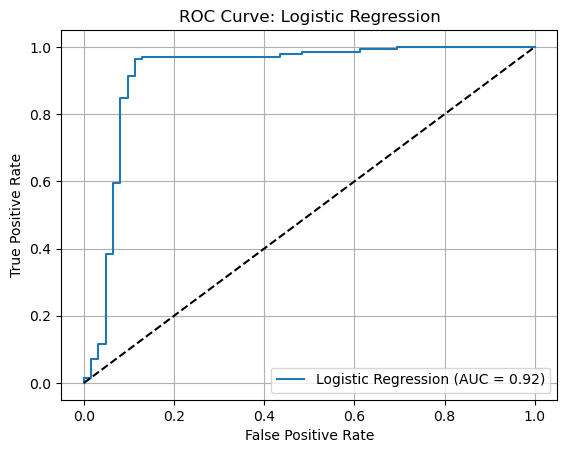

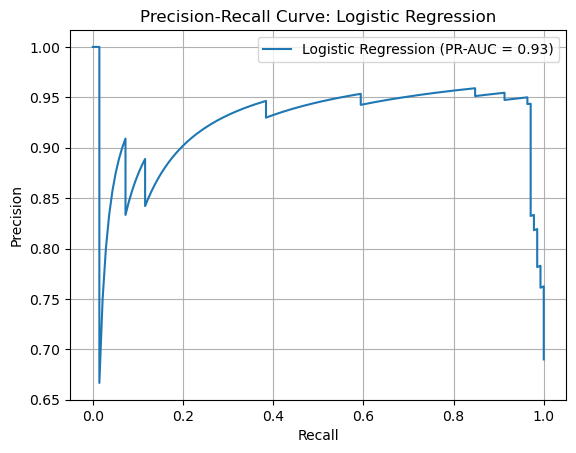


 Training and tuning: SVM


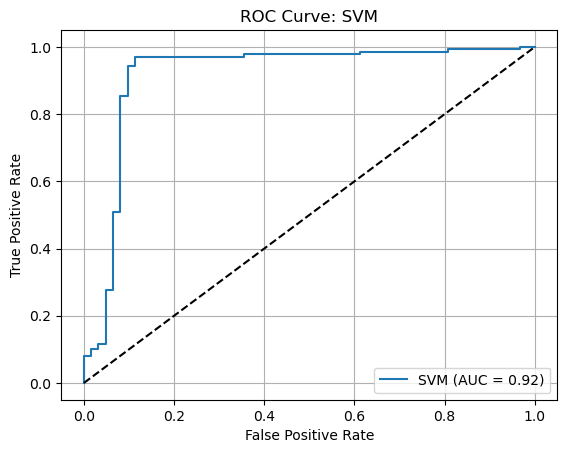

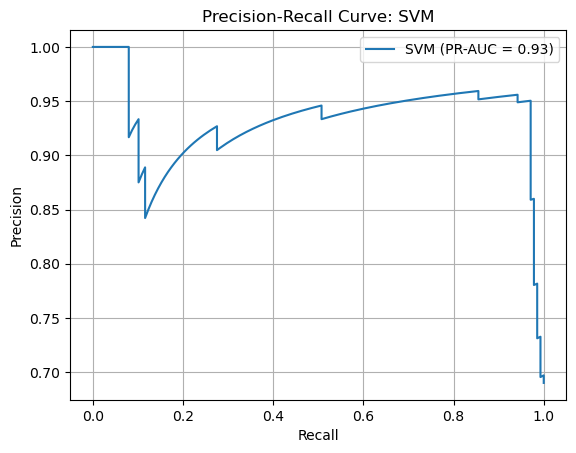

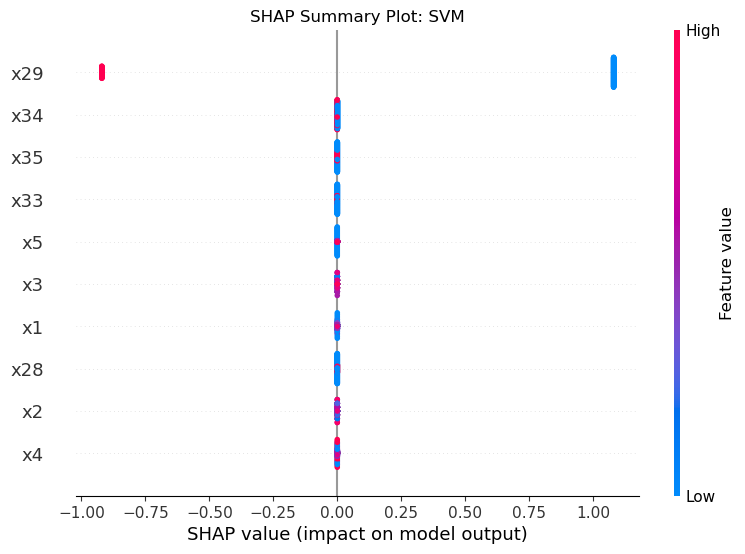


 Training and tuning: Random Forest


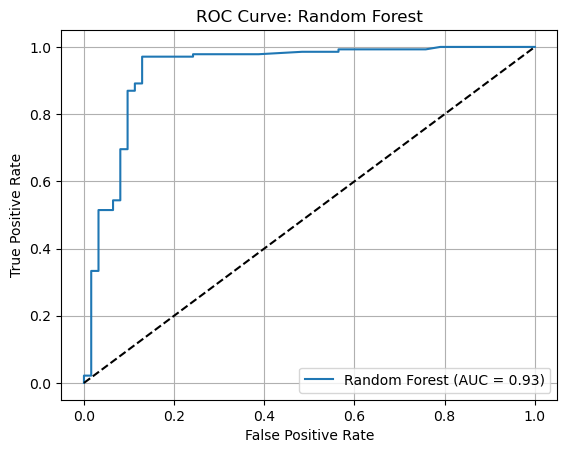

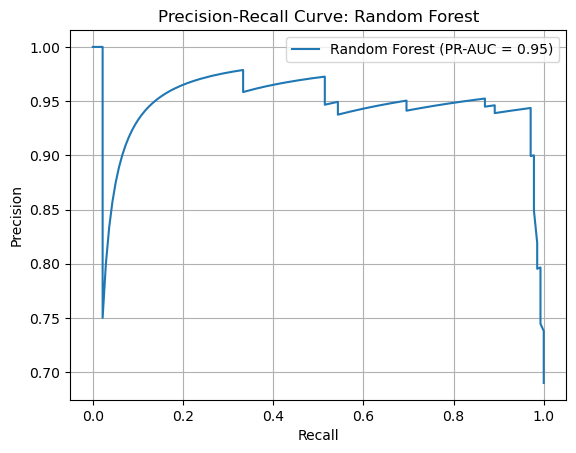

<Figure size 640x480 with 0 Axes>

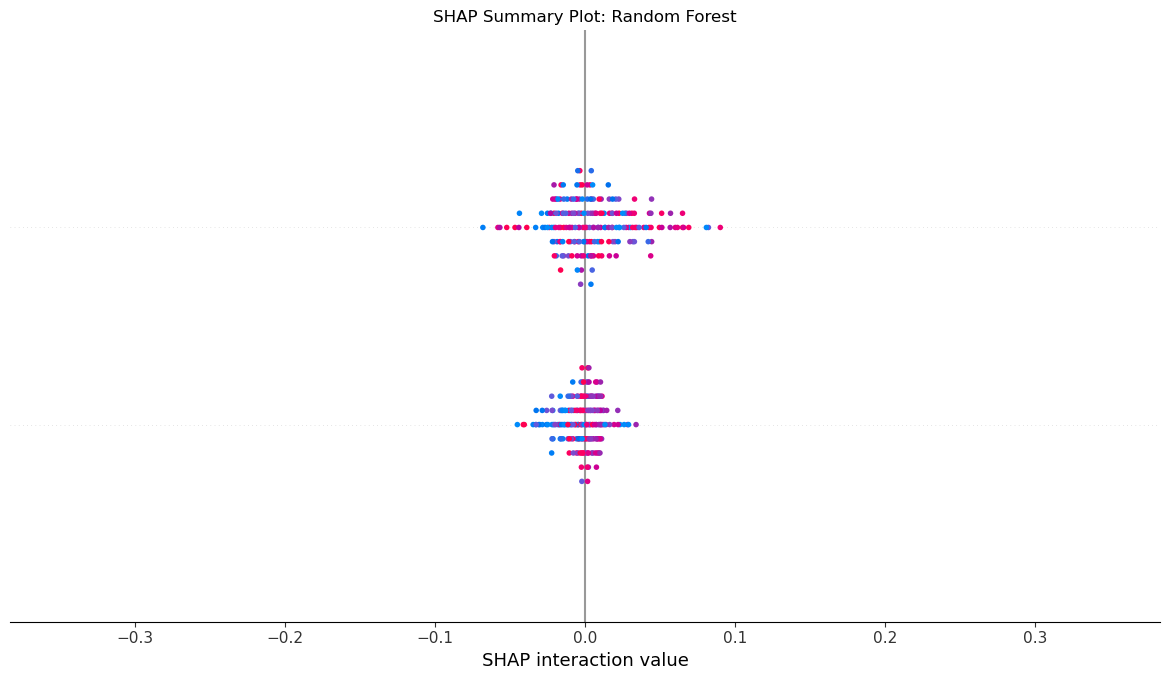


 Training and tuning: XGBoost


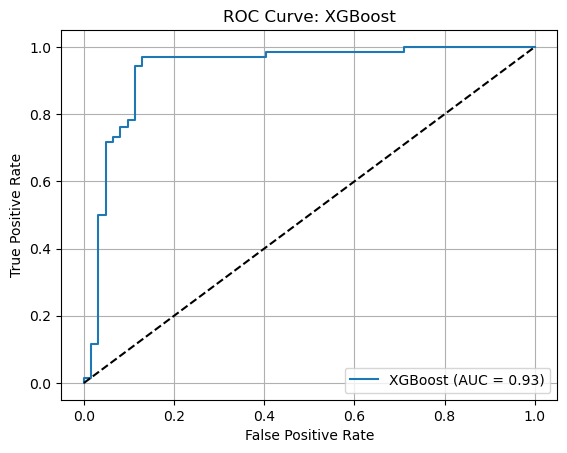

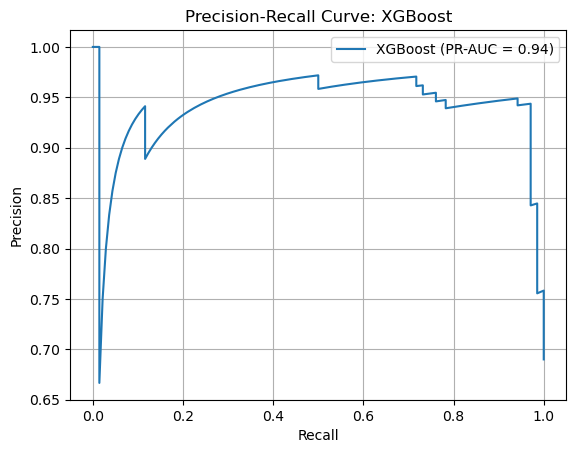

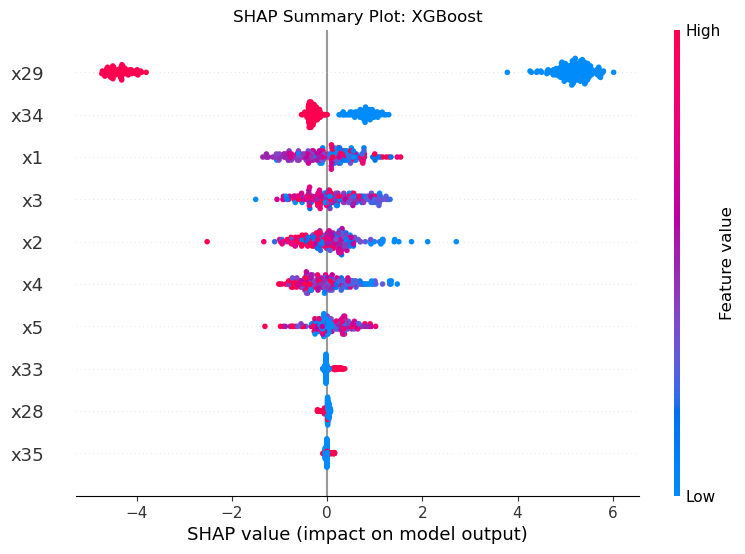


 Model Evaluation Summary:
                     Accuracy   ROC-AUC  F1-Score  Precision    Recall
Logistic Regression      0.94  0.921576  0.957143   0.943662  0.971014
SVM                      0.94  0.916900  0.957143   0.943662  0.971014
Random Forest            0.94  0.930809  0.957143   0.943662  0.971014
XGBoost                  0.93  0.932211  0.949640   0.942857  0.956522


In [2]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
}


models = {
    "Logistic Regression": GridSearchCV(LogisticRegression(max_iter=1000), param_grids["Logistic Regression"], cv=cv, scoring='f1', n_jobs=-1),
    "SVM": GridSearchCV(SVC(probability=True), param_grids["SVM"], cv=cv, scoring='f1', n_jobs=-1),
    "Random Forest": GridSearchCV(RandomForestClassifier(), param_grids["Random Forest"], cv=cv, scoring='f1', n_jobs=-1),
    "XGBoost": GridSearchCV(XGBClassifier(eval_metric='logloss'), param_grids["XGBoost"], cv=cv, scoring='f1', n_jobs=-1)
}


results = {}

for name, model in models.items():
    print(f"\n Training and tuning: {name}")
    model.fit(X_train_selected, y_train_ohe_bal)
    best_model = model.best_estimator_
    preds = best_model.predict(X_test_selected)
    probs = best_model.predict_proba(X_test_selected)[:, 1]

    
    acc = accuracy_score(y_test, preds)
    roc = roc_auc_score(y_test, probs)
    report = classification_report(y_test, preds, output_dict=True)
    results[name] = {
        "Accuracy": acc,
        "ROC-AUC": roc,
        "F1-Score": report['1']['f1-score'],
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall']
    }



    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

    
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (PR-AUC = {pr_auc:.2f})")
    plt.title(f"Precision-Recall Curve: {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()

    
    if name in ["SVM", "Random Forest", "XGBoost"]:
        explainer = shap.Explainer(best_model, X_train_selected)
        shap_vals = explainer(X_test_selected)
        shap.summary_plot(shap_vals, X_test_selected, feature_names=selector.get_feature_names_out(), show=False)
        plt.title(f"SHAP Summary Plot: {name}")
        plt.show()

results_df = pd.DataFrame(results).T
print("\n Model Evaluation Summary:")
print(results_df)



 Training and tuning: Logistic Regression


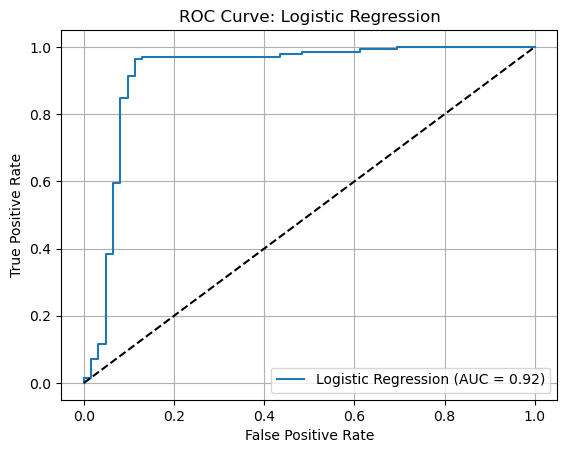

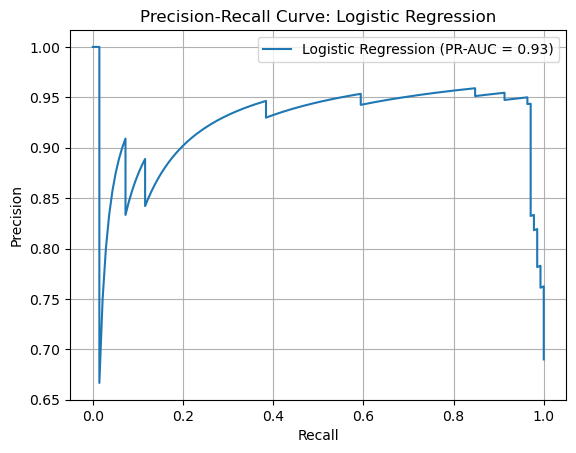

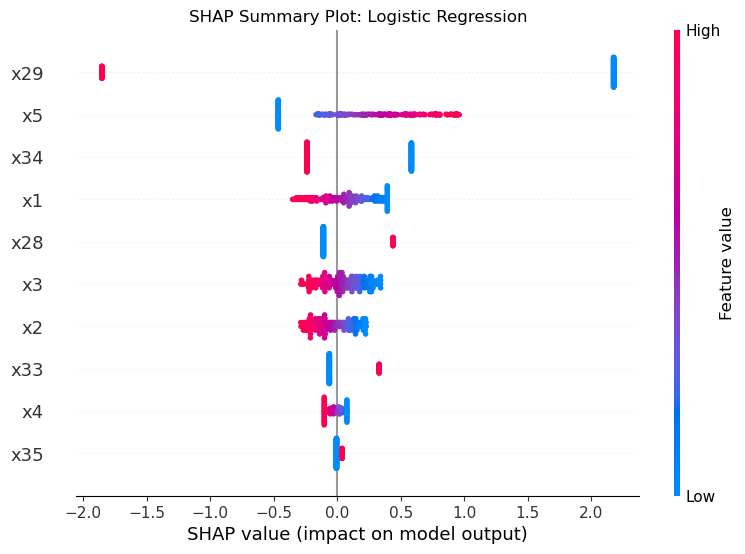


 Training and tuning: SVM


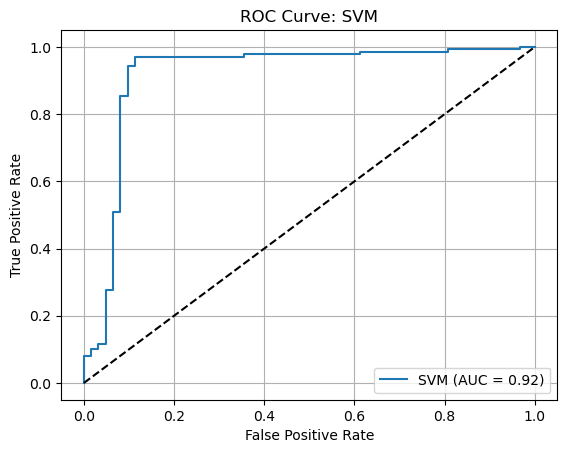

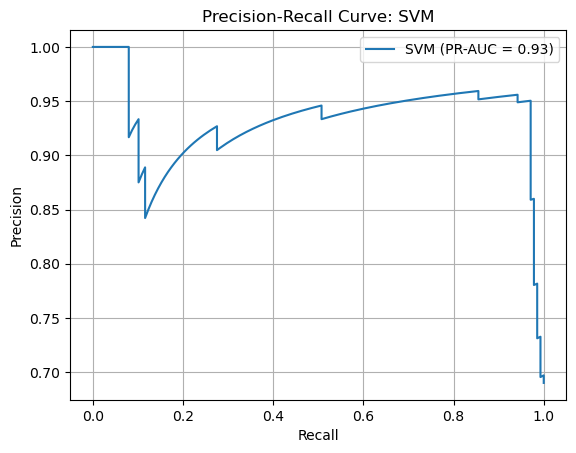

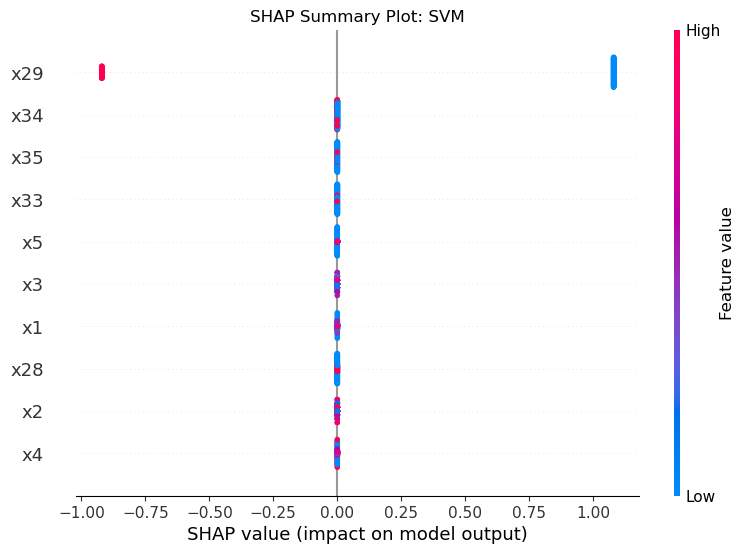


 Training and tuning: Random Forest


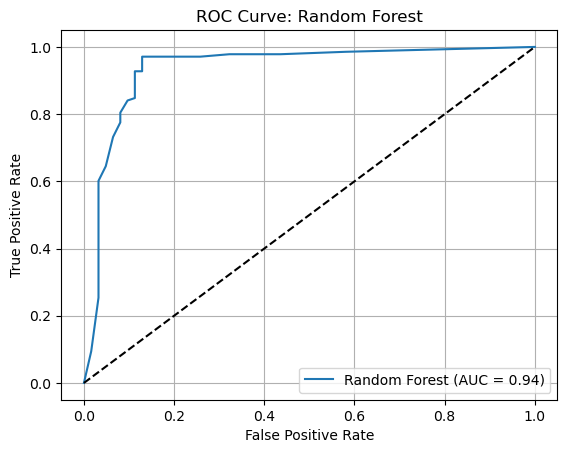

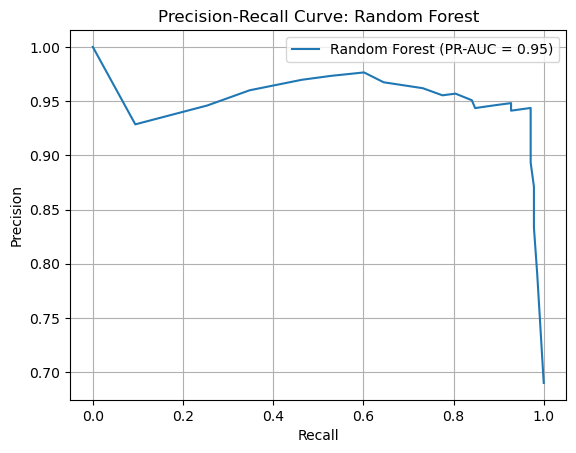

<Figure size 640x480 with 0 Axes>

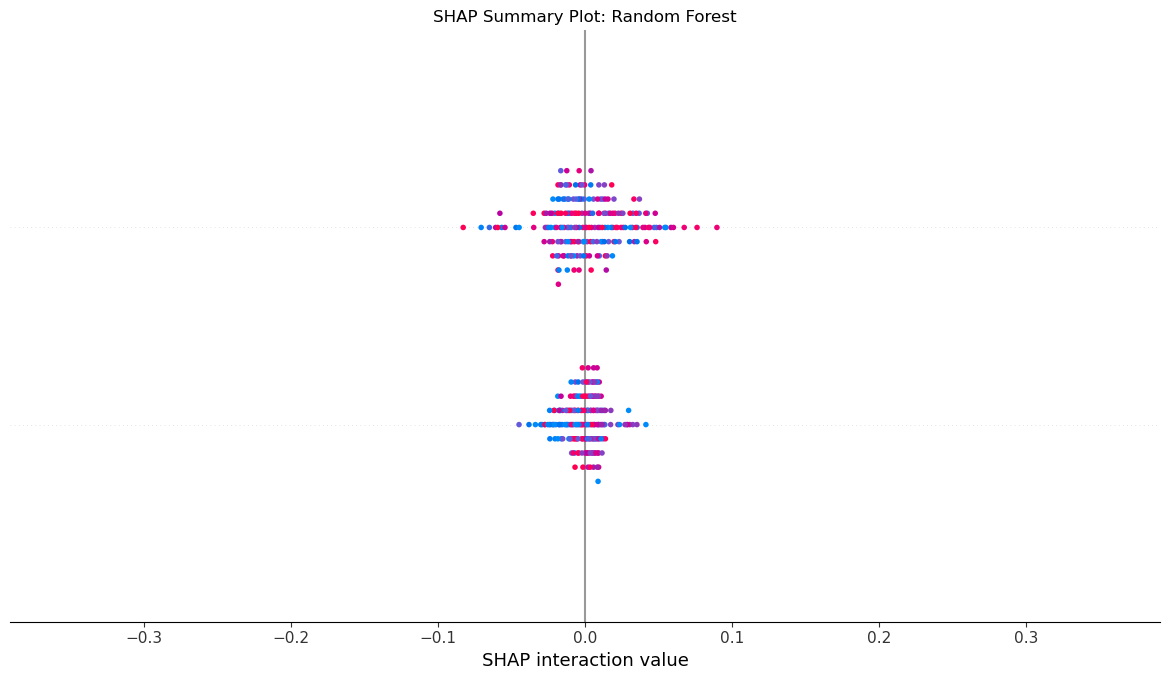


 Training and tuning: XGBoost


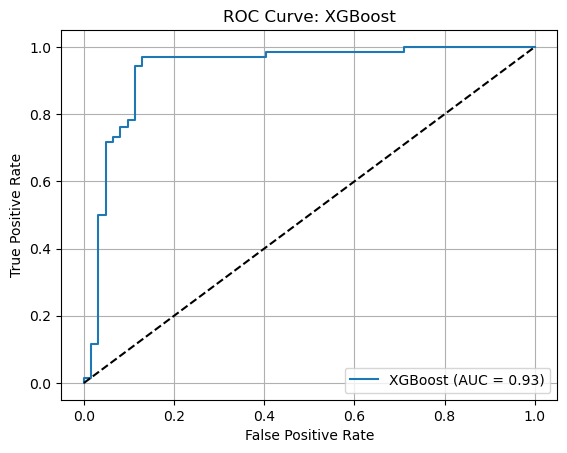

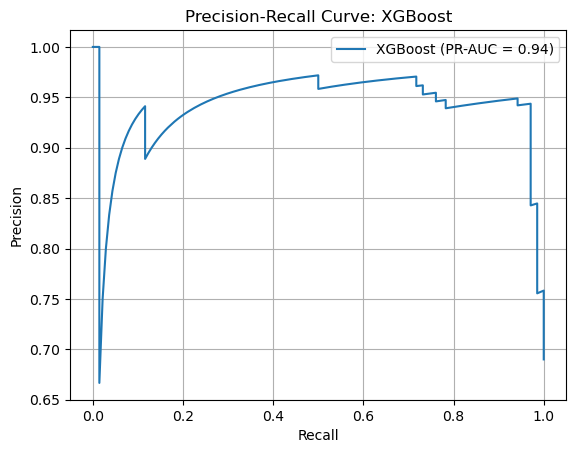

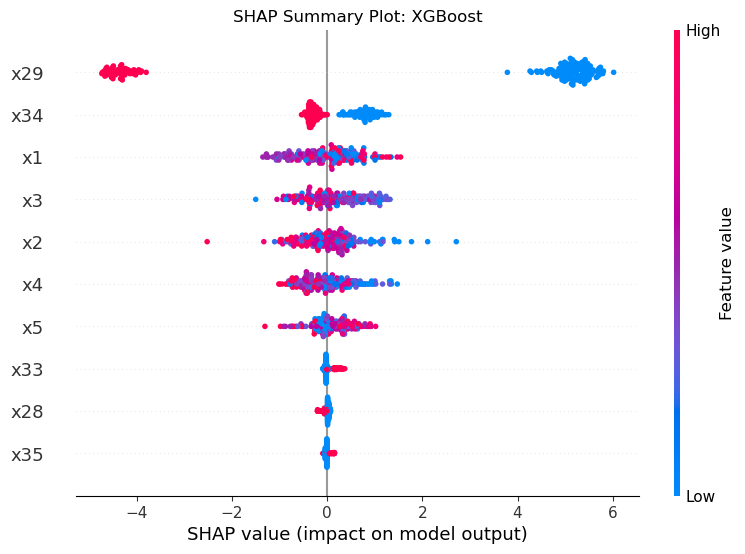


 Training and tuning: Decision Tree


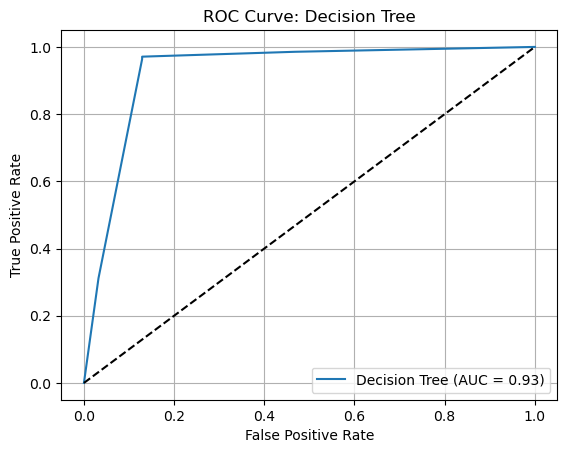

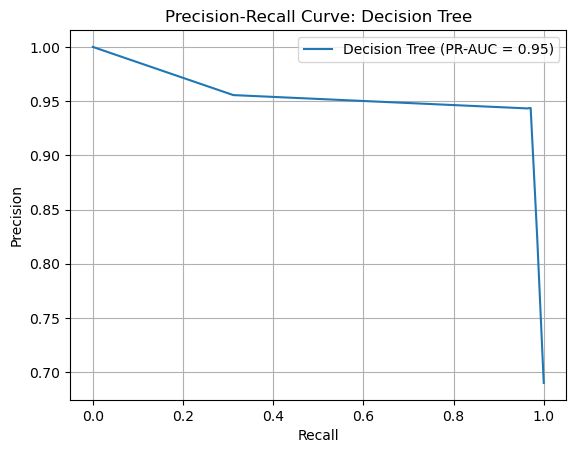

<Figure size 640x480 with 0 Axes>

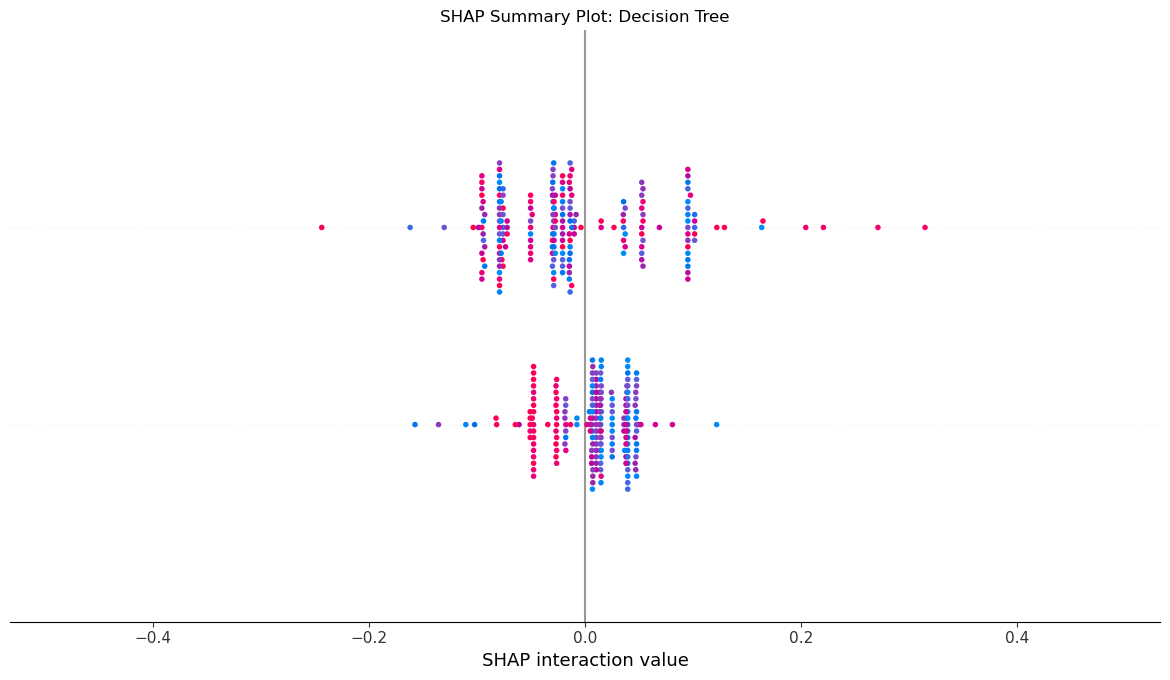


🔧 Training Voting Classifier...


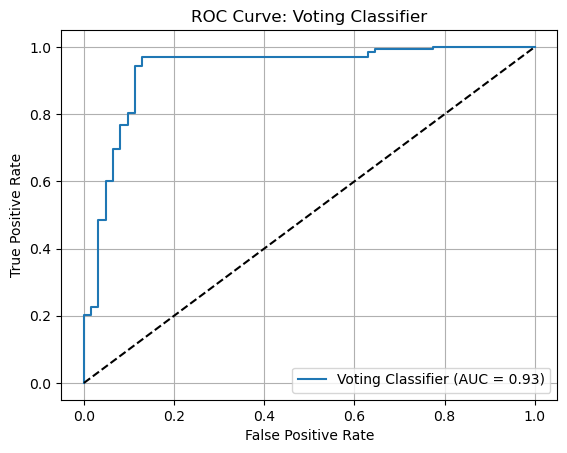

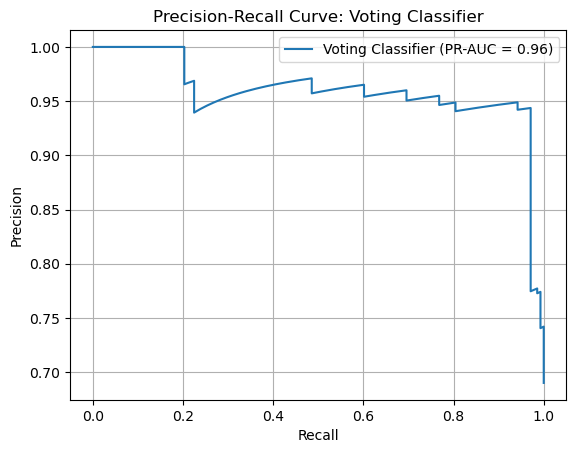


 Final Model Evaluation Summary:
                     Accuracy   ROC-AUC  F1-Score  Precision    Recall
Logistic Regression      0.94  0.921576  0.957143   0.943662  0.971014
SVM                      0.94  0.916900  0.957143   0.943662  0.971014
Random Forest            0.94  0.936185  0.957143   0.943662  0.971014
XGBoost                  0.93  0.932211  0.949640   0.942857  0.956522
Decision Tree            0.94  0.926484  0.957143   0.943662  0.971014
Voting Classifier        0.94  0.931510  0.957143   0.943662  0.971014


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

dt_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
models["Decision Tree"] = GridSearchCV(DecisionTreeClassifier(), dt_grid, cv=cv, scoring='f1', n_jobs=-1)


for name, model in models.items():
    print(f"\n Training and tuning: {name}")
    model.fit(X_train_selected, y_train_ohe_bal)
    best_model = model.best_estimator_
    preds = best_model.predict(X_test_selected)
    probs = best_model.predict_proba(X_test_selected)[:, 1]

    
    acc = accuracy_score(y_test, preds)
    roc = roc_auc_score(y_test, probs)
    report = classification_report(y_test, preds, output_dict=True)
    results[name] = {
        "Accuracy": acc,
        "ROC-AUC": roc,
        "F1-Score": report['1']['f1-score'],
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall']
    }
    
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (PR-AUC = {pr_auc:.2f})")
    plt.title(f"Precision-Recall Curve: {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()

    
    if name in ["Random Forest", "XGBoost", "Decision Tree", "Logistic Regression", "SVM"]:
        explainer = shap.Explainer(best_model, X_train_selected)
        shap_vals = explainer(X_test_selected)
        shap.summary_plot(shap_vals, X_test_selected, feature_names=selector.get_feature_names_out(), show=False)
        plt.title(f"SHAP Summary Plot: {name}")
        plt.show()
    

voting_clf = VotingClassifier(estimators=[
    ('lr', models["Logistic Regression"].best_estimator_),
    ('rf', models["Random Forest"].best_estimator_),
    ('xgb', models["XGBoost"].best_estimator_)
], voting='soft')


print("\n🔧 Training Voting Classifier...")
voting_clf.fit(X_train_selected, y_train_ohe_bal)
preds_vc = voting_clf.predict(X_test_selected)
probs_vc = voting_clf.predict_proba(X_test_selected)[:, 1]


acc = accuracy_score(y_test, preds_vc)
roc = roc_auc_score(y_test, probs_vc)
report = classification_report(y_test, preds_vc, output_dict=True)
results["Voting Classifier"] = {
    "Accuracy": acc,
    "ROC-AUC": roc,
    "F1-Score": report['1']['f1-score'],
    "Precision": report['1']['precision'],
    "Recall": report['1']['recall']
}



fpr, tpr, _ = roc_curve(y_test, probs_vc)
plt.plot(fpr, tpr, label=f"Voting Classifier (AUC = {roc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve: Voting Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, probs_vc)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"Voting Classifier (PR-AUC = {pr_auc:.2f})")
plt.title("Precision-Recall Curve: Voting Classifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


results_df = pd.DataFrame(results).T
print("\n Final Model Evaluation Summary:")
print(results_df)


In [5]:
import numpy as np

# Define a helper function to print unique predictions and probability range
def check_predictions(model, name, X_test_selected):
    preds = model.predict(X_test_selected)
    probs = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n {name}")
    print("Unique Predictions:", np.unique(preds))
    if probs is not None:
        print("Probability Range:", (np.min(probs), np.max(probs)))
        print("Mean Probability:", np.mean(probs))
    return preds, probs

# Run for each trained best model
model_preds = {}
model_probs = {}

for model_name in ["Logistic Regression", "SVM", "Random Forest", "XGBoost", "Decision Tree", "Voting Classifier"]:
    model = models[model_name].best_estimator_ if model_name != "Voting Classifier" else voting_clf
    preds, probs = check_predictions(model, model_name, X_test_selected)
    model_preds[model_name] = preds
    model_probs[model_name] = probs



 Logistic Regression
Unique Predictions: [0 1]
Probability Range: (0.01961421258687393, 0.9809895180567275)
Mean Probability: 0.6656954205735297

 SVM
Unique Predictions: [0 1]
Probability Range: (0.017213386585399237, 0.9382238531454388)
Mean Probability: 0.6710889932824814

 Random Forest
Unique Predictions: [0 1]
Probability Range: (0.0, 1.0)
Mean Probability: 0.67025

 XGBoost
Unique Predictions: [0 1]
Probability Range: (0.00017265978, 0.9997143)
Mean Probability: 0.6961722

 Decision Tree
Unique Predictions: [0 1]
Probability Range: (0.0, 1.0)
Mean Probability: 0.6820745044391703

 Voting Classifier
Unique Predictions: [0 1]
Probability Range: (0.006806909075427109, 0.9861509687802285)
Mean Probability: 0.6784391926575268
